In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import import_ipynb
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

tf.reset_default_graph()

In [2]:
import preprocessing as prep
import constants as c

importing Jupyter notebook from preprocessing.ipynb
importing Jupyter notebook from audio_prep.ipynb
importing Jupyter notebook from constants.ipynb
importing Jupyter notebook from midi_prep.ipynb


In [3]:
def conv2d_reshape(cqt_matrices, midi_matrices):
    """
    Transpose both matrices (spectrogram and MIDI one-hot) to be in format [frames, frequency_bins/one-hot]
    and reshape given wav matrices into the right input shape for Keras Conv2D network: (batch, rows, cols, channels)
    
    Args:
    wav_matrices: array of CQT spectrograms (splitted into frames)
    midi_matrices: labels for frames, represented as one-hot vectors
    
    Return:
    Concatenated arrays of spectrograms and labels, which are used as input for neural network
    """
    
    cqt_reshaped = [np.array(cqt_chunk) for cqt_chunk in cqt_matrices]
    cqt_reshaped = np.concatenate(cqt_reshaped)
    cqt_reshaped = np.array([cqt.T for cqt in cqt_reshaped])
    cqt_reshaped = np.array([cqt.reshape(2*c.CHUNK_PADDING, c.BINS_NUMBER, 1) for cqt in cqt_reshaped])
    
    midi_reshaped = [midi_chunk.T for midi_chunk in midi_matrices]
    midi_reshaped = np.concatenate(midi_reshaped)  
    
    return cqt_reshaped, midi_reshaped

def create_conv_model(input_heigth, input_width, num_classes):
    """
    Create convolutional acoustic model inspired by Kelz 2016
    Paper: On The Potential Of Simple Framewise Approaches To Piano Transcription
    
    Model created using Keras high-level API: https://www.tensorflow.org/guide/keras
    """
    
    input_shape = (input_heigth, input_width, 1)
    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid'))
    adam_opt = Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam_opt,
                  metrics=['acc'])
    return model

def create_classic_conv_model(input_heigth, input_width, num_classes):
    from tensorflow.keras.layers import Input
    
    inputs = Input(shape=(input_heigth, input_width, 1))
    model = Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='valid')(inputs)
    model = Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='valid')(model)
    model = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='same')(model)
    model = Dropout(0.25)(model)
    model = Conv2D(filters=96, kernel_size=(3, 3), activation='relu', padding='valid')(model)
    model = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='same')(model)
    model = Dropout(0.25)(model)
    model = Flatten()(model)
    outputs = Dense(num_classes, activation='sigmoid')(model)
    
    return tf.keras.Model(inputs, outputs)
    

def train_model(cqt_train, cqt_test, midi_train, midi_test, n_classes=88):    
    height, width, depth = cqt_train[0].shape
    epochs = 5
    
    model = create_conv_model(height, width, n_classes)
    history = model.fit(cqt_train, midi_train, validation_data=(cqt_test, midi_test), epochs=epochs, batch_size=64)
    
    # Evaulation of accuracy and loss history
    # Inspiration from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

def generator_train_model(dataset, n_classes=88):    
    height, width = c.SEQUENCE_CHUNK_LENGTH + 2*c.CHUNK_PADDING, c.BINS_NUMBER
    epochs = 5
    
    model = create_conv_model(height, width, n_classes)
    model.summary()
    history = model.fit(dataset.make_one_shot_iterator(), steps_per_epoch=2)
    
    # Evaulation of accuracy and loss history
    # Inspiration from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [7]:
dataset1 = prep.get_dataset()
# it = dataset1.make_initializable_iterator()

# el = it.get_next()
# def gen():   
#     with tf.Session() as sess:
#         sess.run(it.initializer)
#         while True:
#             x_batch, y_batch = sess.run(el)
#             print(x_batch.shape, y_batch.shape)
#             yield x_batch, y_batch

In [ ]:
adam_opt = Adam(lr=0.0001, decay=1e-5)
model = create_classic_conv_model(c.SEQUENCE_CHUNK_LENGTH + 2*c.CHUNK_PADDING, c.BINS_NUMBER, 88)
model.compile(loss='binary_crossentropy',
                  optimizer=adam_opt)
model.fit(dataset1.make_one_shot_iterator(), steps_per_epoch=8)

Aligning single pair of CQT spectrogram and MIDI matrix
Both matrices aligned to 7752 frames.


In [6]:
model = generator_train_model(dataset1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 625, 262, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 623, 260, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 623, 130, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 623, 130, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 621, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxP

InvalidArgumentError: Incompatible shapes: [8,625,88] vs. [8,88]
	 [[{{node metrics/acc/Equal}}]]

In [8]:
ws2 = np.array(prep.wav_chunks[0])
wavs_reshaped2 = np.array([w.T for w in ws2])
wsr2 = np.array([w.reshape(4, 264, 1) for w in wavs_reshaped2])
msr2 = prep.midi_chunks[0].T

In [75]:
midi_predicted = model.predict(cqt_m)

In [76]:
midi_predicted = midi_predicted.T

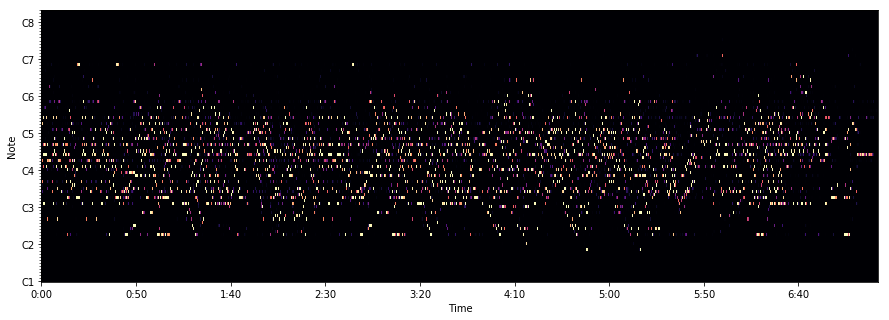

In [77]:
prep.mp.plot_piano_roll(midi_predicted[:,:])

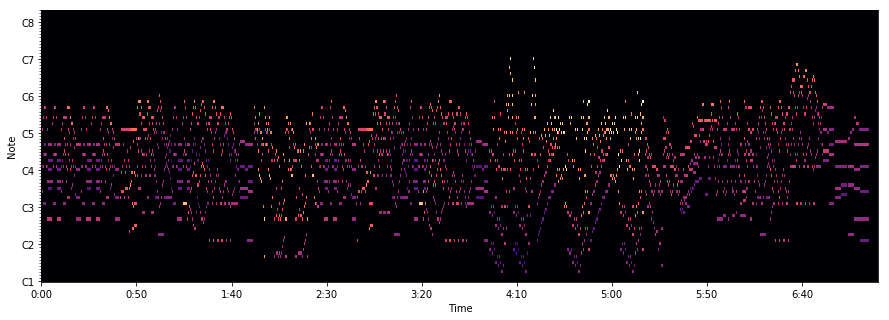

In [70]:
midi_m = prep.pretty_midi.PrettyMIDI('D:\School\Bc\model\MAPS\AkPnBcht\MUS\MAPS_MUS-scn16_2_AkPnBcht.mid')
midi_m = midi_m.get_piano_roll(fs=c.FRAME_LENGTH)[c.MIDI_MIN:c.MIDI_MAX+1, :]
prep.mp.plot_piano_roll(midi_m)

In [72]:
cqt_m = prep.ap.cqt_matrix('D:\School\Bc\model\MAPS\AkPnBcht\MUS\MAPS_MUS-scn16_2_AkPnBcht.wav')
cqt_m = prep.log_normalization(cqt_m)

In [73]:
cqt_m = prep.ap.split_wav(cqt_m)

In [74]:
cqt_m = np.array([np.array(w).T for w in cqt_m])
cqt_m = np.array([w.reshape(4, 264, 1) for w in cqt_m])
cqt_m.shape

(19046, 4, 264, 1)

In [53]:
mid_trunc = np.array([[0 if x < 0.35 else 1 for x in m] for m in midi_predicted])

In [44]:
mid_trunc.shape

(88, 10679)